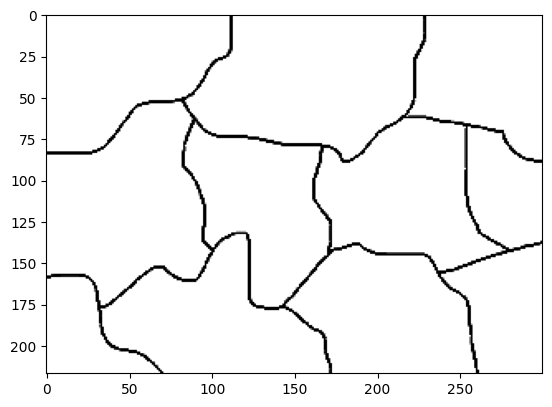

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

org_image = cv2.imread('map.png')
plt.imshow(org_image)
plt.show()

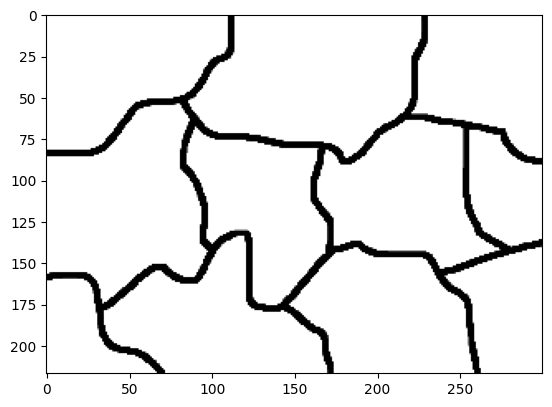

In [3]:
gray_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3), np.uint8)
gray_image = cv2.erode(gray_image, kernel, iterations=1)
plt.imshow(gray_image)
plt.gray()
plt.show()

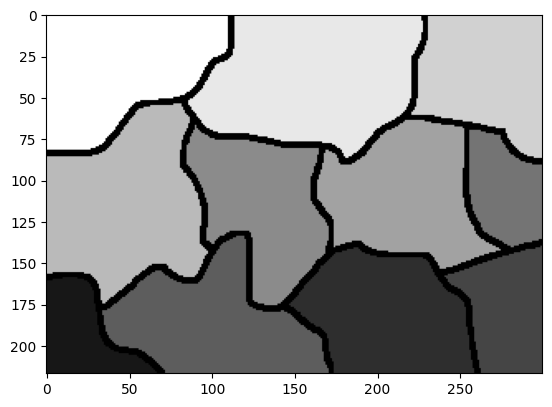

In [4]:
contours, _ = cv2.findContours(gray_image, cv2.RETR_TREE,
                               cv2.CHAIN_APPROX_SIMPLE)[-2:]
for i,cnt in enumerate(contours):
    gray_image = cv2.drawContours(gray_image, [cnt], 0, i+1, cv2.FILLED)

plt.imshow(gray_image)
plt.show()

In [5]:
nc = len(contours)
adjacent = [set() for _ in range(nc+1)] # adjacent[ID] = set of IDs

h, w = gray_image.shape
D = 5
for i,cnt in enumerate(contours):
    for x,y in cnt.reshape(-1,2):
        if (D <= x < w - D) and (D <= y < h - D):
            surroundings = set(gray_image[y-D:y+D+1, x-D:x+D+1].ravel())
            adjacent[i+1] |= surroundings

for i in range(1, nc + 1):
    adjacent[i] -= set([0, i])
    for j in adjacent[i]:
        if i in adjacent[j]:
            adjacent[j].remove(i)
    print(i, ':', adjacent[i])

1 : {4, 8}
2 : {3, 4, 6, 7}
3 : {5, 7}
4 : {6, 8}
5 : {7, 9}
6 : {7, 8, 10}
7 : {9, 10}
8 : {10, 11}
9 : {10}
10 : {11}
11 : set()


In [6]:
from simpleai.search import CspProblem, backtrack

names = list(range(1, nc+1))
colors = dict((name, ['red', 'green', 'blue', 'gray']) for name in names)

def constraint_func(names, values):
    return values[0] != values[1]

constraints = [((a, b), constraint_func)
                   for a in range(1, nc+1)
                       for b in adjacent[a]]

problem = CspProblem(names, colors, constraints)
output = backtrack(problem)
print('Color mapping:')
for k, v in output.items():
    print(k, '==>', v)

Color mapping:
1 ==> red
2 ==> red
3 ==> green
4 ==> green
5 ==> red
6 ==> blue
7 ==> gray
8 ==> gray
9 ==> green
10 ==> red
11 ==> green


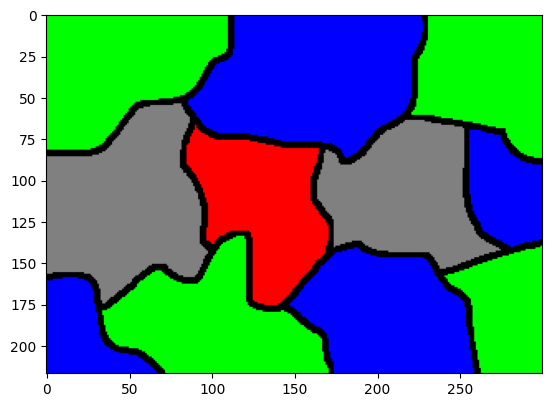

In [7]:
cvalues = {'red':(0,0,255), 'green':(0,255,0), 
           'blue':(255,0,0), 'gray':(128,128,128)}

dst_image = np.zeros((h, w, 3), np.uint8)
for i, cnt in enumerate(contours):
    dst_image = cv2.drawContours(dst_image, [cnt], 0, 
                                 cvalues[output[i+1]], cv2.FILLED)
plt.imshow(dst_image)
plt.show()